# #This file contains the unit tests.

Checking file: C:\Users\kikas\OneDrive\projects\Capstone Project - HealthInsurance Fraud\data\Beneficiarydata.csv
File exists: True
Checking file: C:\Users\kikas\OneDrive\projects\Capstone Project - HealthInsurance Fraud\data\Inpatientdata.csv
File exists: True
Checking file: C:\Users\kikas\OneDrive\projects\Capstone Project - HealthInsurance Fraud\data\Outpatientdata.csv
File exists: True
Checking file: C:\Users\kikas\OneDrive\projects\Capstone Project - HealthInsurance Fraud\data\Providerdata.csv
File exists: True
Loaded files: ['Beneficiarydata', 'Inpatientdata', 'Outpatientdata', 'Providerdata']
Missing files: []
Created table Beneficiarydata with 138,556 rows
Created table Inpatientdata with 40,474 rows
Created table Outpatientdata with 517,737 rows
Created table Providerdata with 5,410 rows
Missing values in Beneficiarydata:
BeneID                                  0
DOB                                     0
DOD                                137135
Gender                         

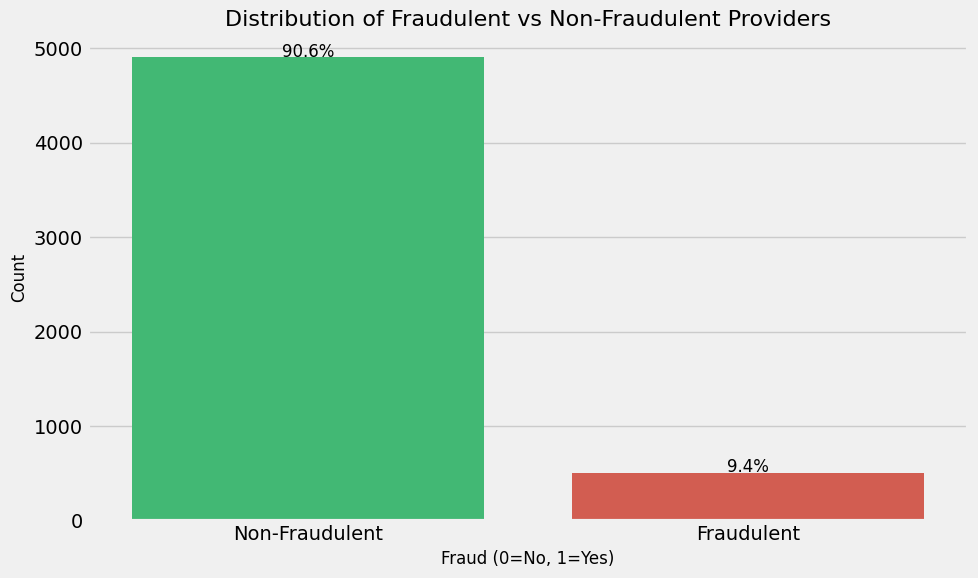

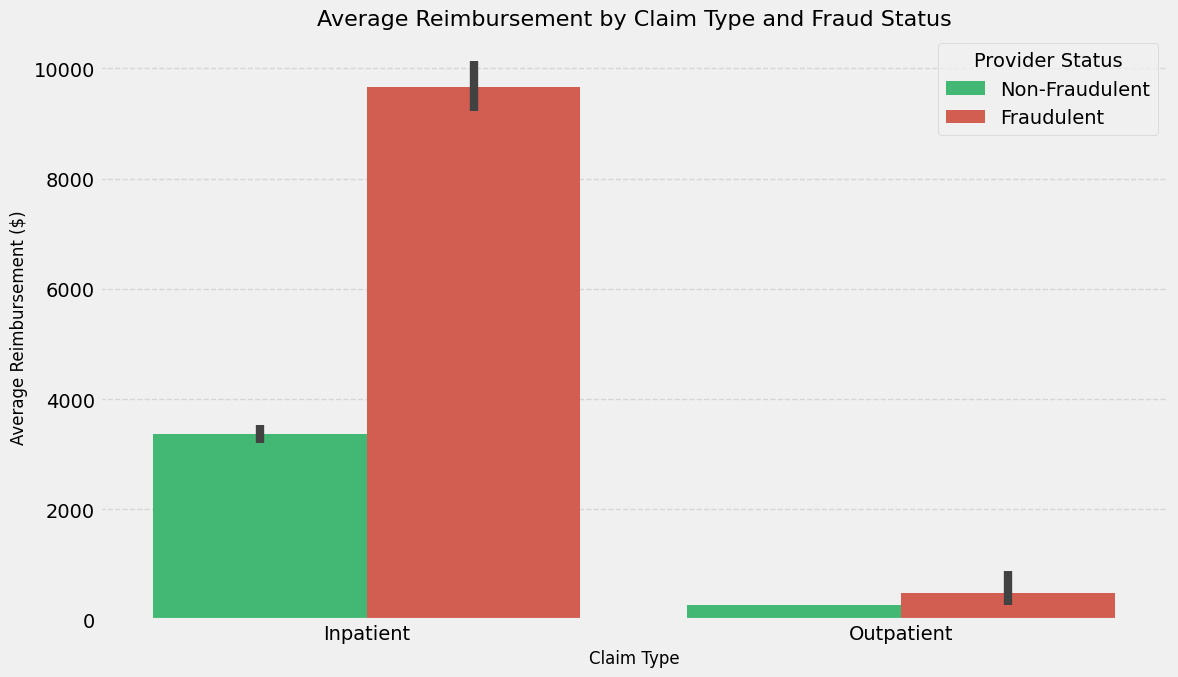

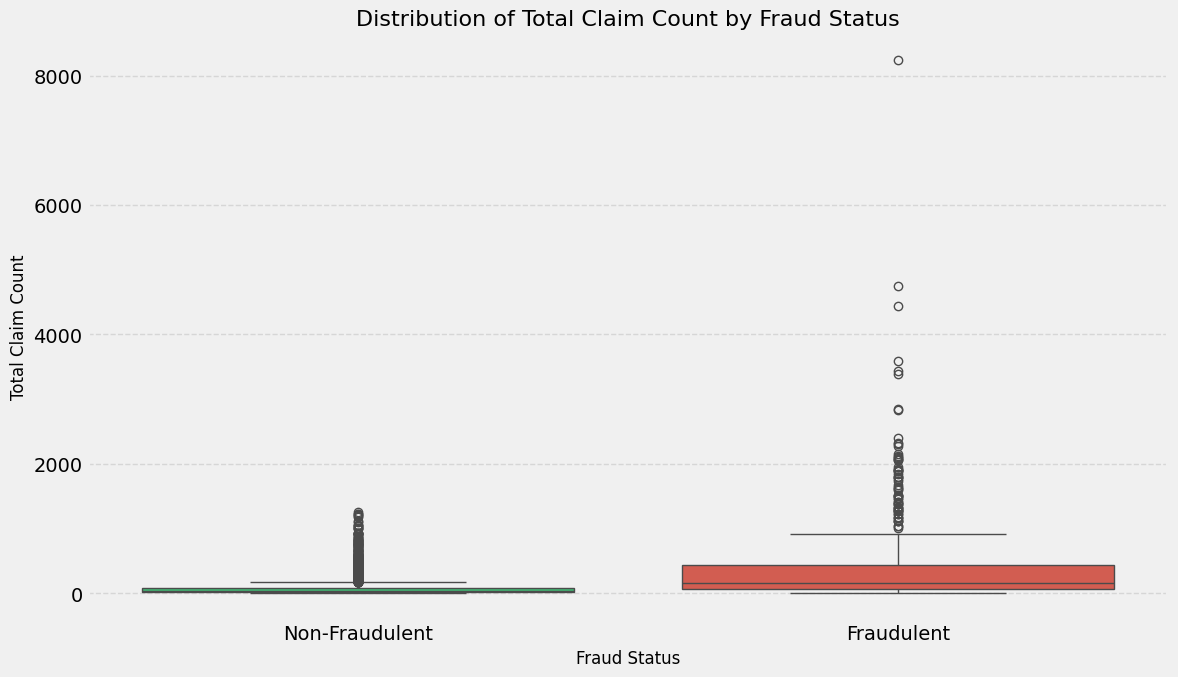

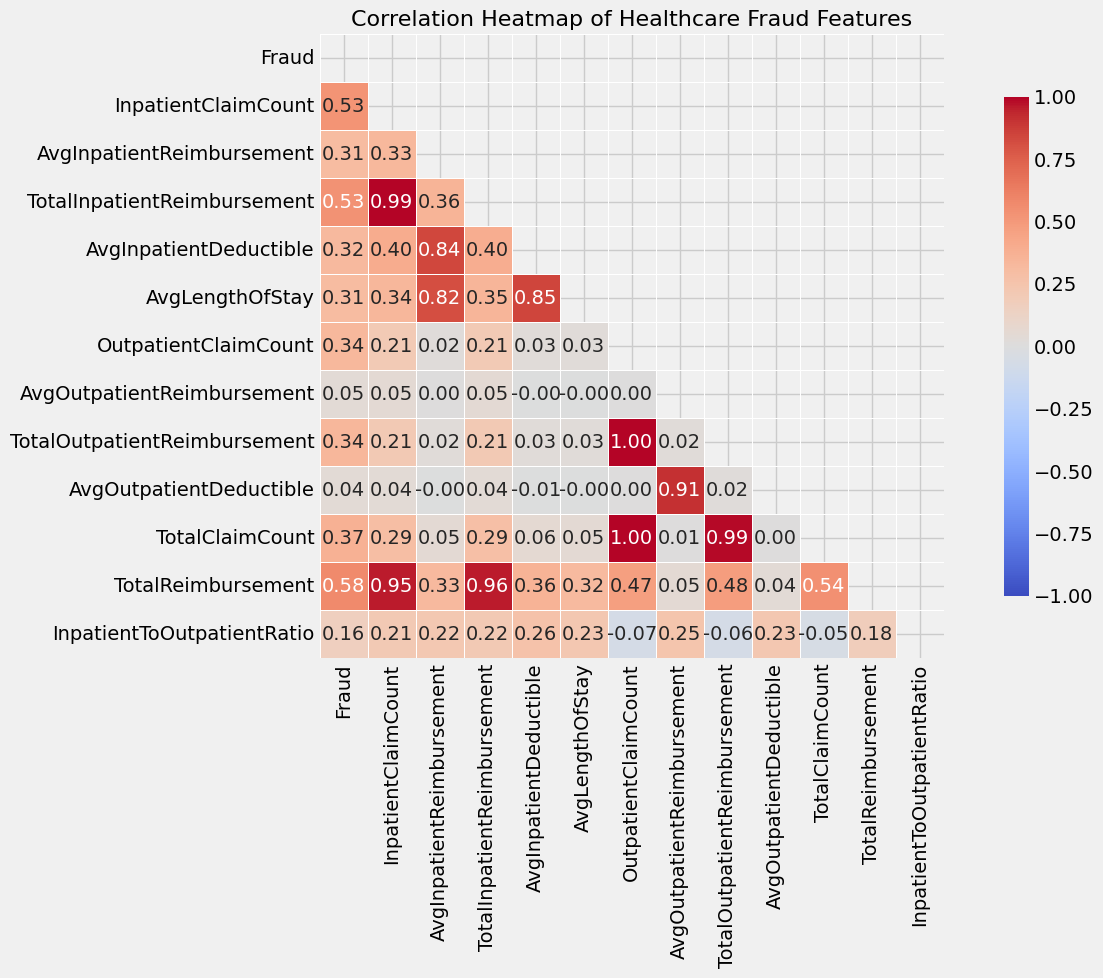

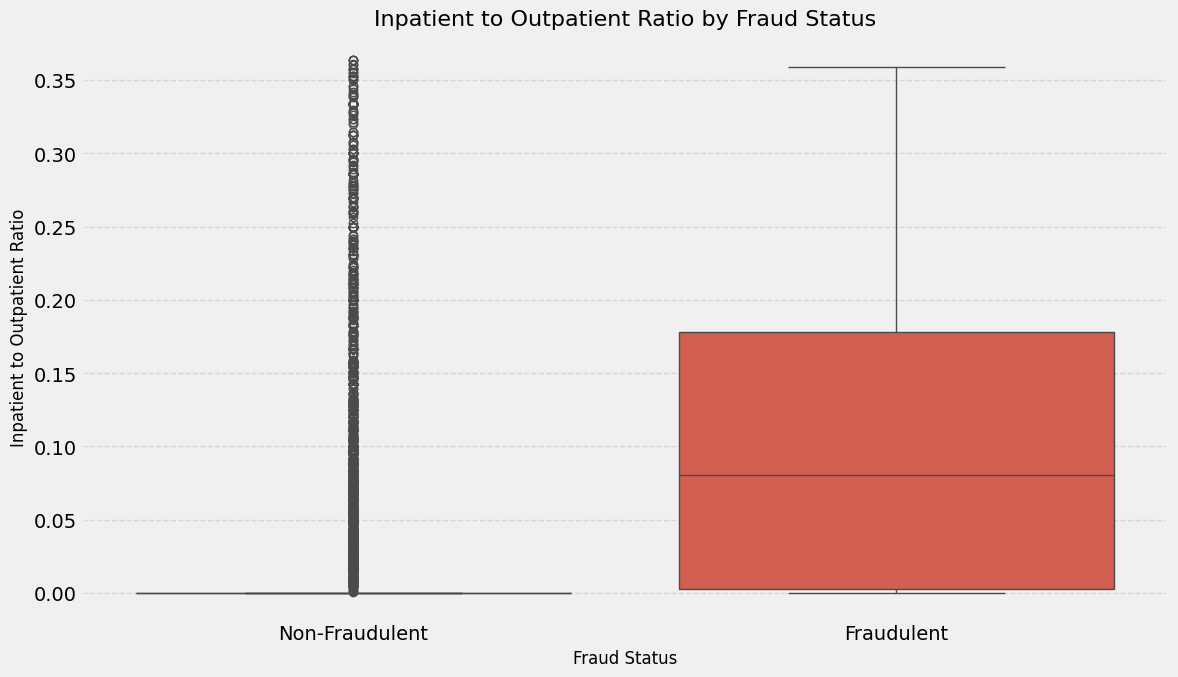

Pivot Table Summary:


AvgInpatientReimbursement           AvgLengthOfStay  \
FraudStatus                               Fraud Non-Fraud           Fraud   
ReimbursementCategory                                                       
Very Low                                   0.00      3.33            0.00   
Low                                        0.00    504.64            0.00   
Medium                                  5008.33   2566.35            5.62   
High                                    9330.48   7251.18            5.75   
Very High                               9923.85   8919.24            5.42   

                                AvgOutpatientReimbursement            \
FraudStatus           Non-Fraud                      Fraud Non-Fraud   
ReimbursementCategory                                                  
Very Low                   0.05                     136.67    184.89   
Low                        0.45                     302.33    332.31   
Medium                     1.67                     233.78    280.85   
High                       3.76                     254.54    253.13   
Very High                  4.77                     511.04    258.18   

                      TotalClaimCount            
FraudStatus                     Fraud Non-Fraud  
ReimbursementCategory                            
Very Low                         3.50      6.18  
Low                             33.25     21.28  
Medium                          36.50     53.68  
High                            98.64    102.79  
Very High                      476.19    235.37

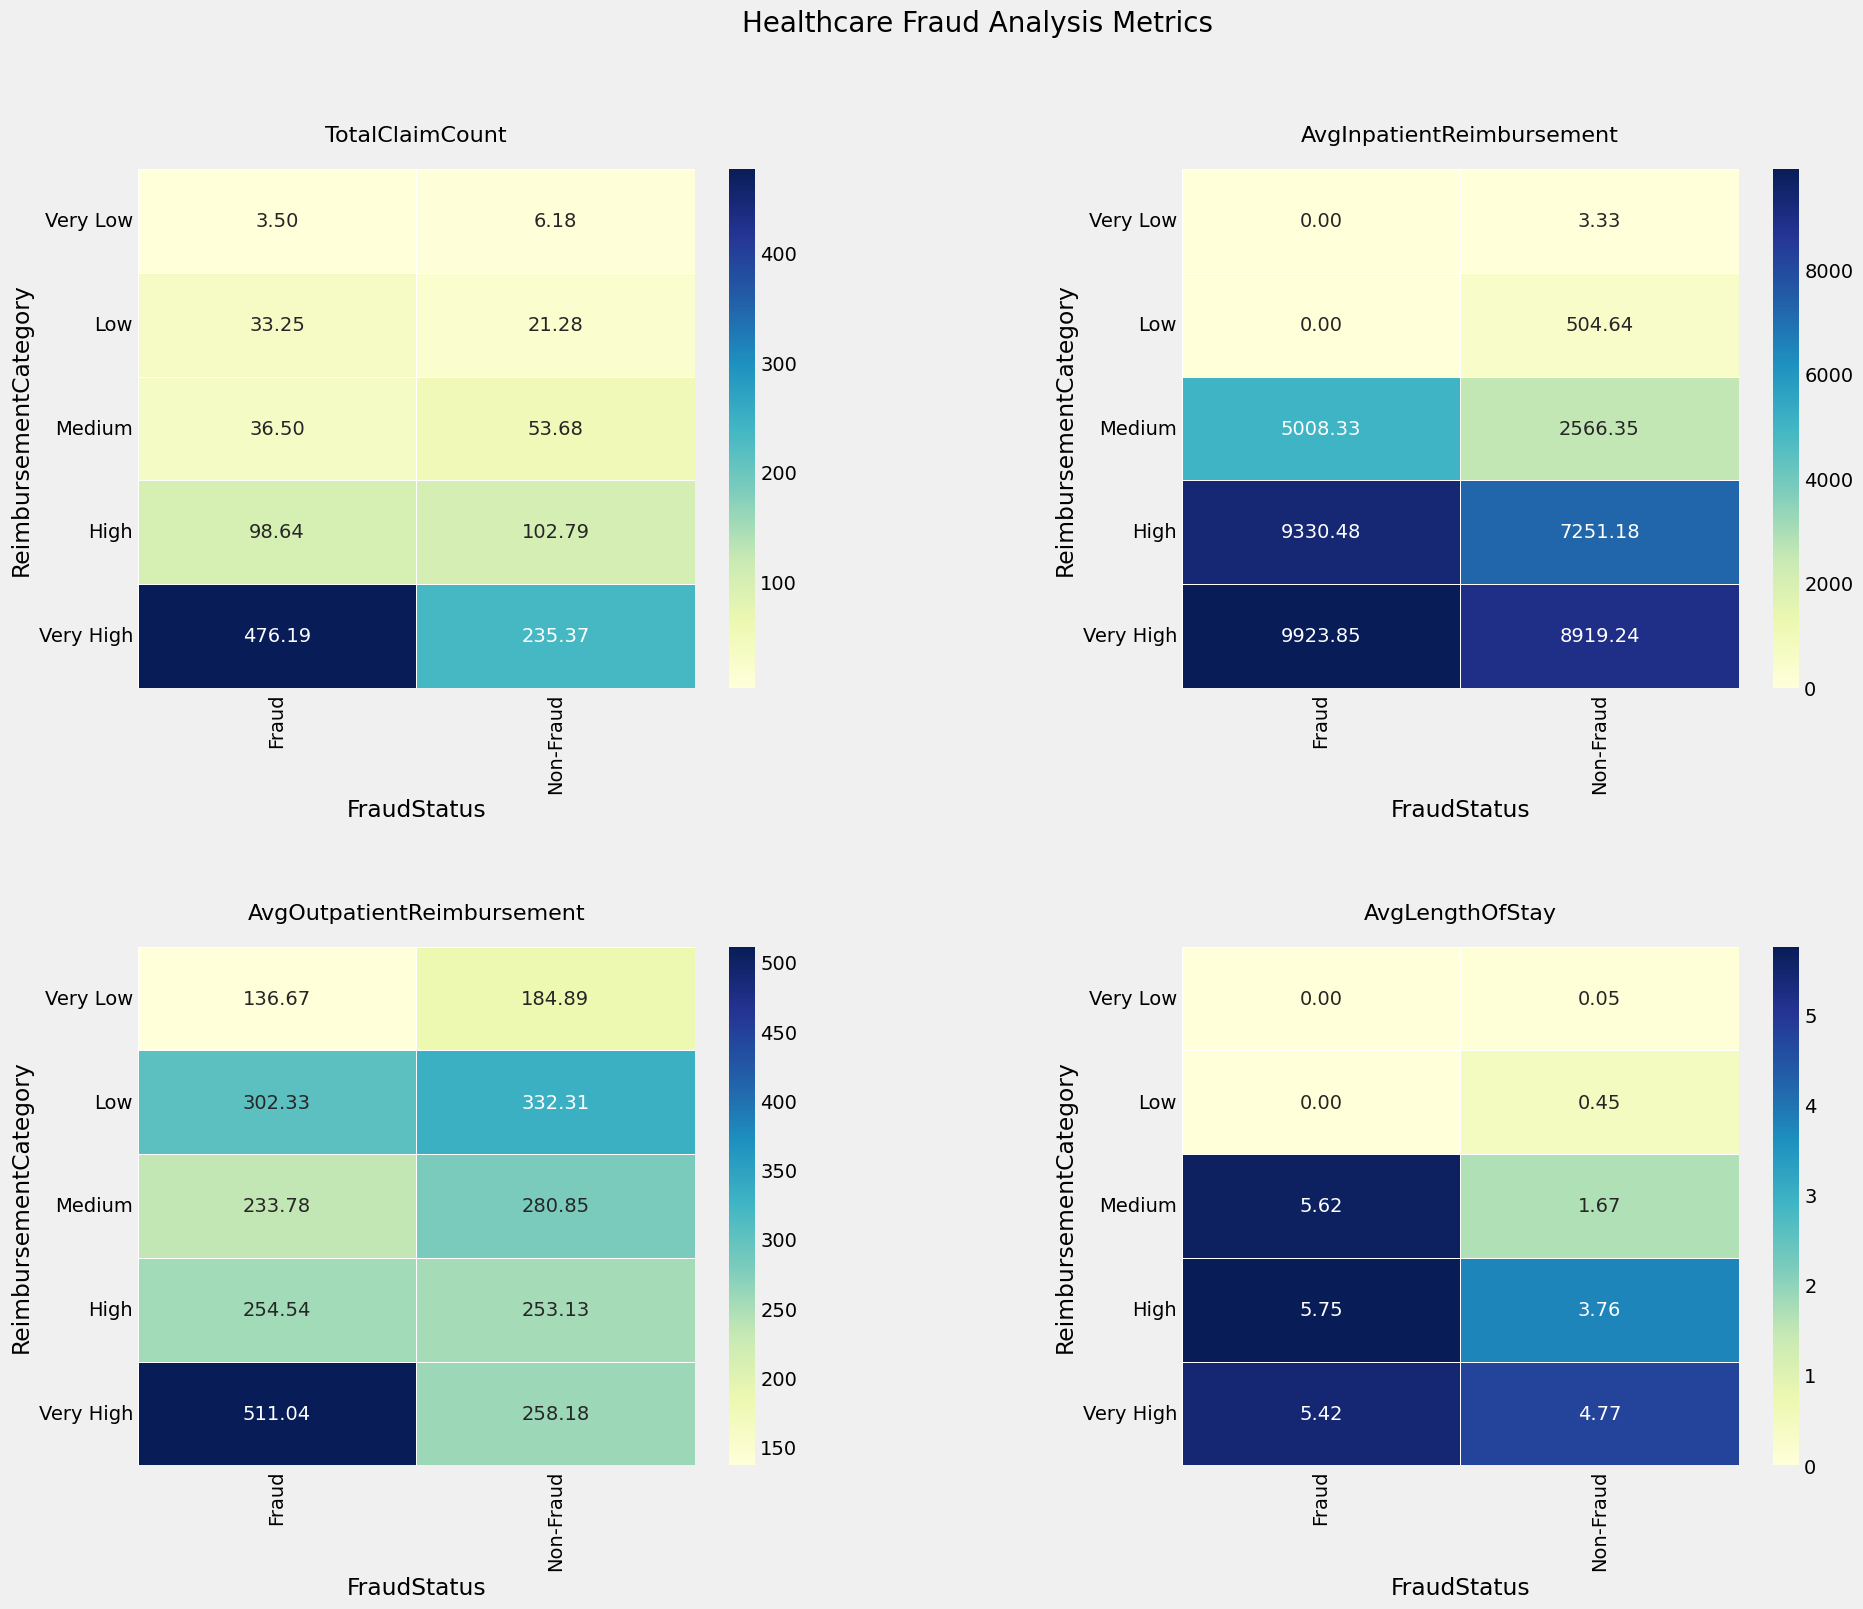

In [2]:
# Import the necessary libraries
import sqlite3
import pandas as pd
import pytest
import import_ipynb 
import FinalCode 


In [4]:
# Import the functions for testing from FinalCode
from FinalCode import create_sqlite_tables, explore_and_clean, sql_join


In [5]:
# Test 1: Ensure using the same database connection
def test_create_sqlite_tables():
    """Test if the function correctly creates tables in the SQLite database."""
    # IMPORTANT: Use the same database file as in FinalCode.ipynb
    conn = sqlite3.connect('healthcare_fraud.db')  # Match the connection in FinalCode
    
    # Print the existing tables before we start (for debugging)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print("Tables before:", cursor.fetchall())
    
    # Prepare test data
    data_dict = {'TestData': pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})}
    
    # Call the function
    create_sqlite_tables(data_dict)
    
    # Check again after running your function
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("Tables after:", tables)
    
    # Verify table creation
    table_names = [table[0] for table in tables]
    assert 'TestData' in table_names
    
    conn.close()
    print("✅ Test 1: create_sqlite_tables PASSED!")



In [6]:
# Test 2: Test explore_and_clean function
def test_explore_and_clean():
    """Test if the explore_and_clean function handles missing values and transformations correctly."""
    data_dict = {
        'Beneficiarydata': pd.DataFrame({
            'DOB': ['1990-01-01', None, '1985-07-14'],
            'Gender': ['M', 'F', None],
            'State': ['CA', None, 'NY'],
            'Race': ['White', None, 'Asian'],
            'County': ['Los Angeles', 'San Francisco', None]
        })
    }
    
    # Call data cleaning function
    try:
        cleaned_data = explore_and_clean(data_dict)
        cleaned_df = cleaned_data['Beneficiarydata']
        
        # Print debugging info
        print("\nCleaned DataFrame head:")
        print(cleaned_df.head())
        print("\nMissing values after cleaning:")
        print(cleaned_df.isnull().sum())
        
        # Check if 'Age' column was added
        assert 'Age' in cleaned_df.columns
        
        # Only check for filled values if there are no missing values
        if cleaned_df['Gender'].isnull().sum() == 0:
            # Check Gender - if mode was M, index 2 should be M
            if cleaned_df['Gender'].mode()[0] == 'M':
                assert cleaned_df['Gender'].iloc[2] == 'M'
        
        if cleaned_df['State'].isnull().sum() == 0:
            # Check State - if mode was CA, index 1 should be CA
            if cleaned_df['State'].mode()[0] == 'CA':
                assert cleaned_df['State'].iloc[1] == 'CA'
        
        print("✅ Test 2: explore_and_clean PASSED!")
    except Exception as e:
        print(f"❌ Test 2 failed: {str(e)}")

In [7]:
# Test 3: Test if SQL join and aggregation work
def test_sql_join():
    """Test if the SQL join function works correctly."""
    # First, set up the database with the required test data
    provider_df = pd.DataFrame({
        'Provider': [1, 2, 3],
        'PotentialFraud': ['No', 'Yes', 'No'],
        'Fraud': [0, 1, 0]
    })
    
    inpatient_df = pd.DataFrame({
        'ClaimID': [101, 102, 103],
        'Provider': [1, 1, 2],
        'InscClaimAmtReimbursed': [1000, 2000, 1500],
        'DeductibleAmtPaid': [100, 200, 150],
        'LengthOfStay': [5, 3, 7]
    })
    
    outpatient_df = pd.DataFrame({
        'ClaimID': [201, 202, 203],
        'Provider': [1, 2, 3],
        'InscClaimAmtReimbursed': [500, 600, 700],
        'DeductibleAmtPaid': [50, 60, 70]
    })
    
    # Create dictionary with dataframes
    data_dict = {
        'Providerdata': provider_df,
        'Inpatientdata': inpatient_df,
        'Outpatientdata': outpatient_df
    }
    
    # Create tables in the database
    create_sqlite_tables(data_dict)
    
    # Call the sql_join function
    try:
        result = sql_join()
        
        # Assertions about the result
        assert isinstance(result, pd.DataFrame)
        assert 'Provider' in result.columns
        assert 'TotalClaimCount' in result.columns
        
        print("✅ Test 3: sql_join PASSED!")
    except Exception as e:
        print(f"❌ Test 3 failed: {str(e)}")


In [8]:
# Function to run all tests
def run_all_tests():
    try:
        test_create_sqlite_tables()
        test_explore_and_clean()
        test_sql_join()
        print("🎉 All tests completed successfully!")
    except Exception as e:
        print(f"❌ Test failed: {str(e)}")

# Run all tests when this file is executed
if __name__ == "__main__":
    run_all_tests()

Tables before: [('Beneficiarydata',), ('Providerdata',), ('Inpatientdata',), ('Outpatientdata',)]
Created table TestData with 2 rows
Tables after: [('Beneficiarydata',), ('Providerdata',), ('Inpatientdata',), ('Outpatientdata',), ('TestData',)]
✅ Test 1: create_sqlite_tables PASSED!
Missing values in Beneficiarydata:
DOB       1
Gender    1
State     1
Race      1
County    1
dtype: int64

Cleaned DataFrame head:
         DOB Gender State   Race         County   Age
0 1990-01-01      M    CA  White    Los Angeles  35.0
1        NaT      F    CA  Asian  San Francisco   NaN
2 1985-07-14      F    NY  Asian    Los Angeles  40.0

Missing values after cleaning:
DOB       1
Gender    0
State     0
Race      0
County    0
Age       1
dtype: int64
✅ Test 2: explore_and_clean PASSED!
Created table Providerdata with 3 rows
Created table Inpatientdata with 3 rows
Created table Outpatientdata with 3 rows
✅ Test 3: sql_join PASSED!
🎉 All tests completed successfully!
